In [1]:
!pip install torch torchvision matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [15]:
batch_size = 16

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [16]:
class CVAE(nn.Module):
    def __init__(self, input_dim=784, label_dim=10, latent_dim=20):
        super(CVAE, self).__init__()
        self.input_dim = input_dim
        self.label_dim = label_dim
        self.latent_dim = latent_dim

        # Encoder
        self.fc1 = nn.Linear(input_dim + label_dim, 400)
        self.fc21 = nn.Linear(400, latent_dim)
        self.fc22 = nn.Linear(400, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim + label_dim, 400)
        self.fc4 = nn.Linear(400, input_dim)

    def encode(self, x, y):
        inputs = torch.cat([x, y], dim=1)
        h1 = F.relu(self.fc1(inputs))
        return self.fc21(h1), self.fc22(h1)  # mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        inputs = torch.cat([z, y], dim=1)
        h3 = F.relu(self.fc3(inputs))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, y), mu, logvar



In [17]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

model = CVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)



In [18]:
epochs = 100

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device).view(-1, 784)
        labels_onehot = F.one_hot(labels, num_classes=10).float().to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data, labels_onehot)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset):.4f}")



Epoch 1, Loss: 127.3791
Epoch 2, Loss: 109.0860
Epoch 3, Loss: 106.0473
Epoch 4, Loss: 104.4595
Epoch 5, Loss: 103.4849
Epoch 6, Loss: 102.8181


KeyboardInterrupt: 

In [15]:
def generate_digit_images(digit, n=5):
    model.eval()
    digit_label = torch.tensor([digit]*n)
    labels_onehot = F.one_hot(digit_label, num_classes=10).float().to(device)
    z = torch.randn(n, model.latent_dim).to(device)
    with torch.no_grad():
        samples = model.decode(z, labels_onehot).cpu().view(-1, 28, 28)
    return samples


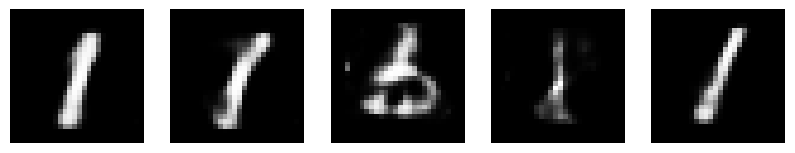

In [16]:
digit = 1  # Choose any digit 0-9
images = generate_digit_images(digit)

fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axs[i].imshow(images[i], cmap='gray')
    axs[i].axis('off')
plt.show()


In [ ]:
torch.save(model.state_dict(), "cvae_mnist.pth")